## Customer Segmentation Using K-Means Clustering for Purchase Behavior Analysis

#### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import gradio as gr
from math import pi

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#### Load Dataset

In [2]:
df = pd.read_csv("Dataset/Customer_Dataset.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### Dataset Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#### Check for Missing Values

In [4]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

#### Feature Selection

In [5]:
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]

#### Feature Distribution Scatter Plot

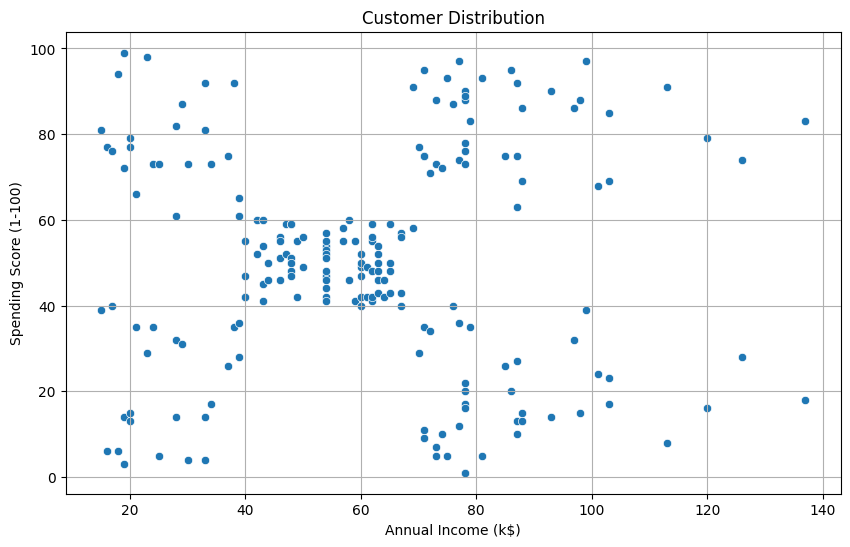

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features[0], y=features[1], data=df)
plt.title("Customer Distribution")
plt.grid(True)
plt.show()

#### Elbow Method to Choose Optimal k

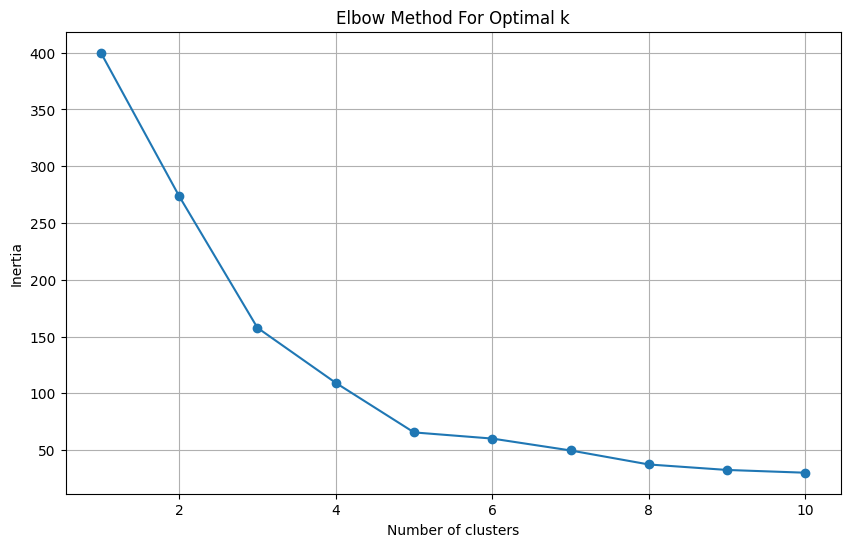

In [7]:
inertias = []
scaled_X = StandardScaler().fit_transform(X)

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

#### Initialize KMeans Model (k=5)

In [8]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
])

#### Fit KMeans Model

In [9]:
pipeline.fit(X)

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300


#### Assign Cluster Labels to DataFrame

In [10]:
df['Cluster'] = pipeline.named_steps['kmeans'].labels_
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


#### Cluster Scatter Plot with Centroids

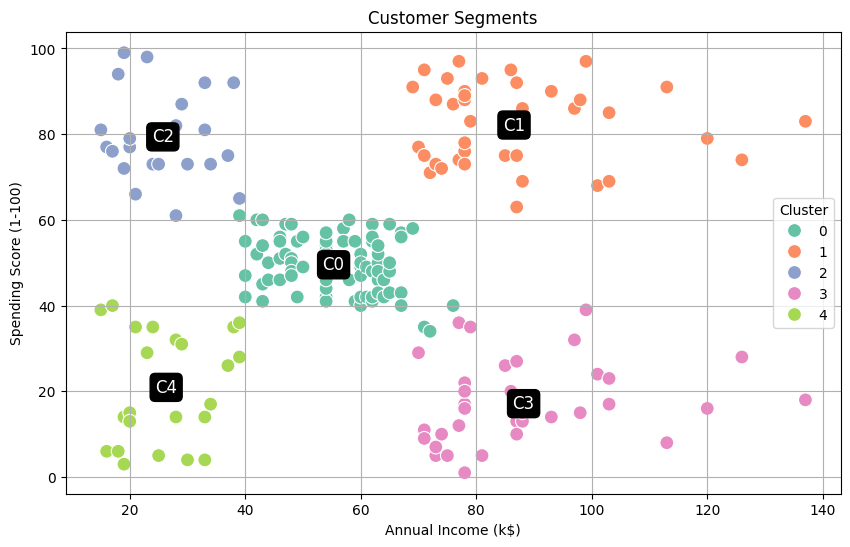

In [11]:
centroids = pipeline.named_steps['scaler'].inverse_transform(
    pipeline.named_steps['kmeans'].cluster_centers_
)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=features[0], y=features[1], hue='Cluster', palette='Set2', s=100)

for i, (x, y) in enumerate(centroids):
    plt.scatter(x, y, s=300, c='black', marker='X')
    plt.text(x, y, f'C{i}', color='white', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='black', boxstyle='round,pad=0.3'))

plt.title("Customer Segments")
plt.grid(True)
plt.show()

#### Bar Chart – Cluster Count

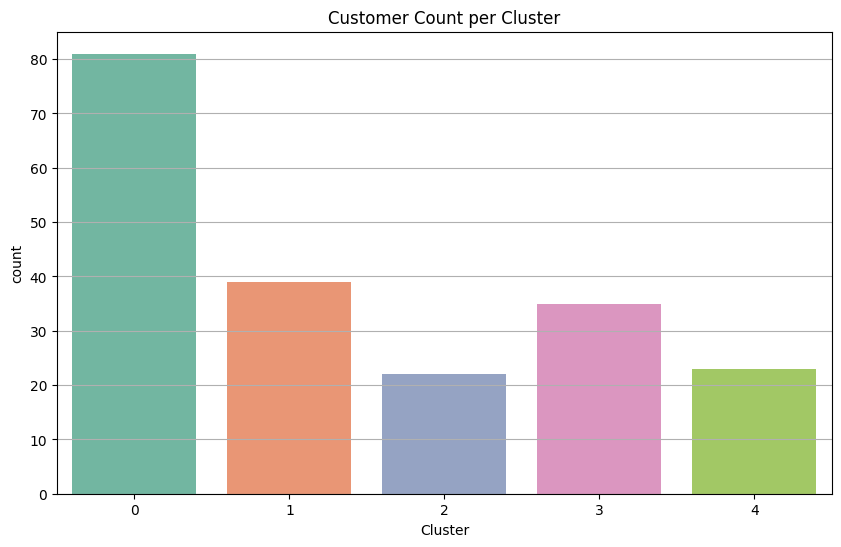

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df, hue='Cluster', palette='Set2', legend=False)
plt.title("Customer Count per Cluster")
plt.grid(axis='y')
plt.show()

#### Pie Chart – Cluster Proportions

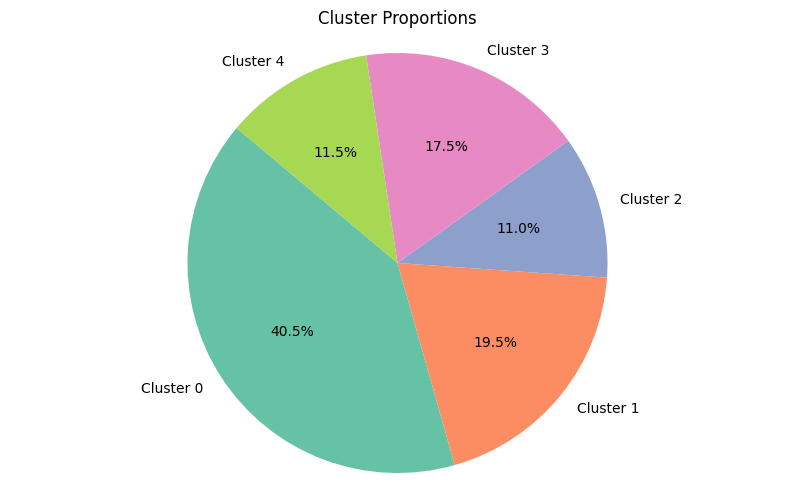

In [13]:
cluster_counts = df['Cluster'].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_counts.index]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 6))
plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Cluster Proportions")
plt.axis('equal')
plt.show()

#### Pair Plot – Features vs Clusters

<Figure size 1000x600 with 0 Axes>

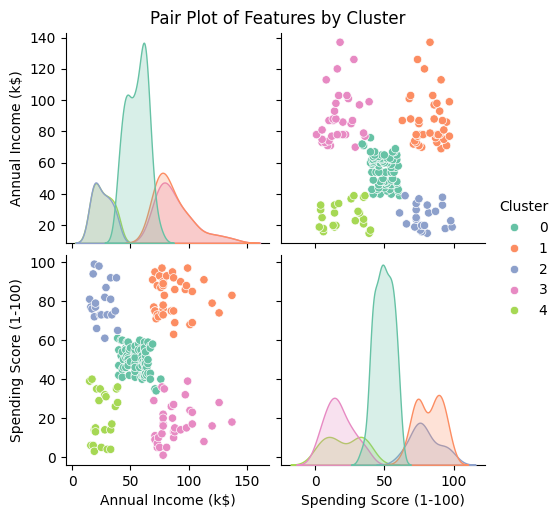

In [14]:
plt.figure(figsize=(10, 6))
sns.pairplot(df[[*features, 'Cluster']], hue='Cluster', palette='Set2', diag_kind='kde')
plt.suptitle("Pair Plot of Features by Cluster", y=1.02)
plt.show()

#### Box Plot – Income by Cluster

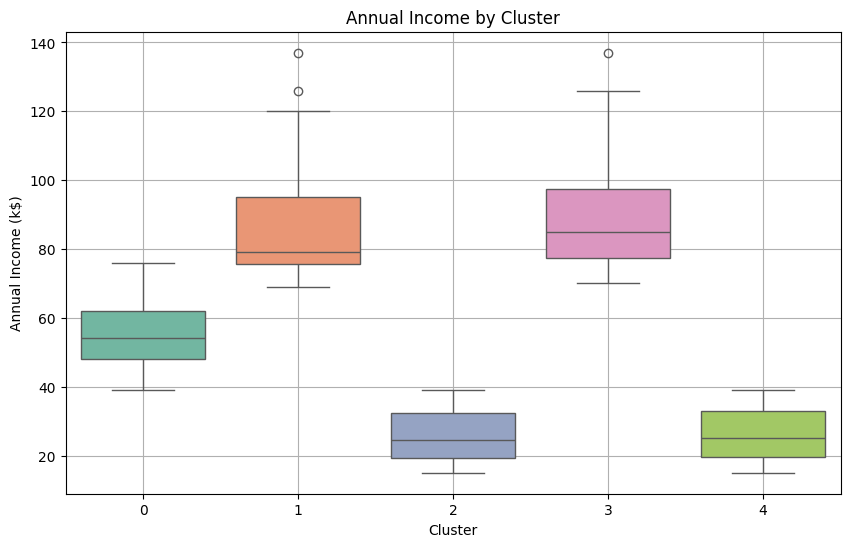

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Annual Income (k$)', data=df, hue='Cluster', palette='Set2', legend=False)
plt.title("Annual Income by Cluster")
plt.grid(True)
plt.show()

#### Box Plot – Spending Score by Cluster

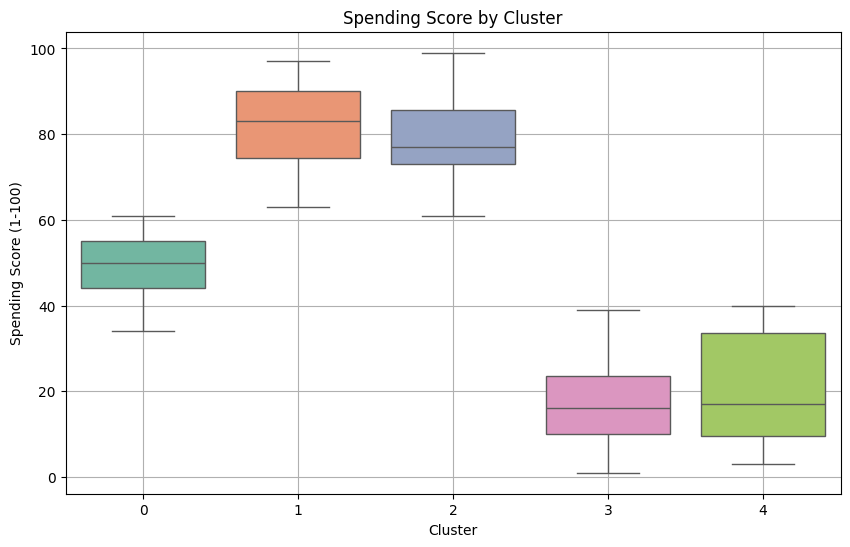

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=df, hue='Cluster', palette='Set2', legend=False)
plt.title("Spending Score by Cluster")
plt.grid(True)
plt.show()

#### KDE Plot – Income vs Spending by Cluster

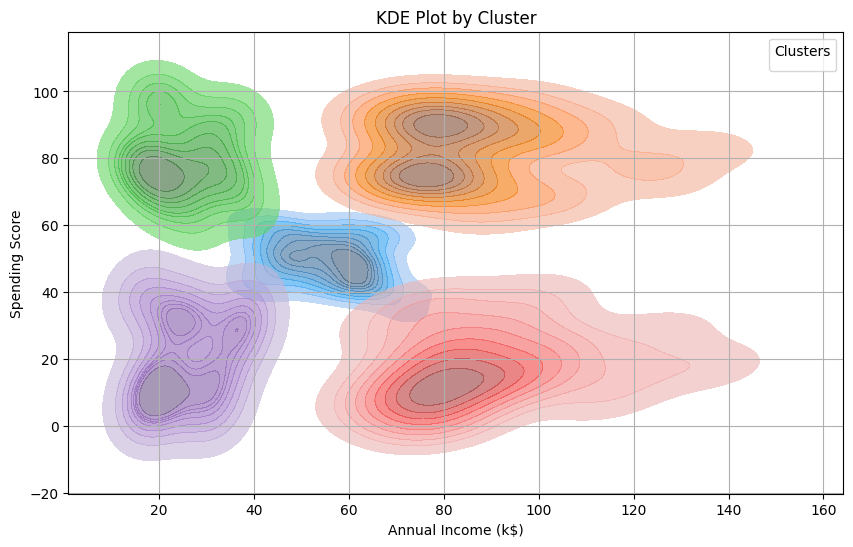

In [17]:
plt.figure(figsize=(10, 6))
artists = [] 
labels = []   

for i in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster'] == i]
    artist = sns.kdeplot(
        x=subset[features[0]],
        y=subset[features[1]],
        fill=True,
        alpha=0.6
    )
    artists.append(artist)
    labels.append(f"Cluster {i}")

# Use legend handles and labels explicitly
plt.title("KDE Plot by Cluster")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.legend(labels, title="Clusters")
plt.grid(True)
plt.show()


#### Heatmap of Cluster Centers

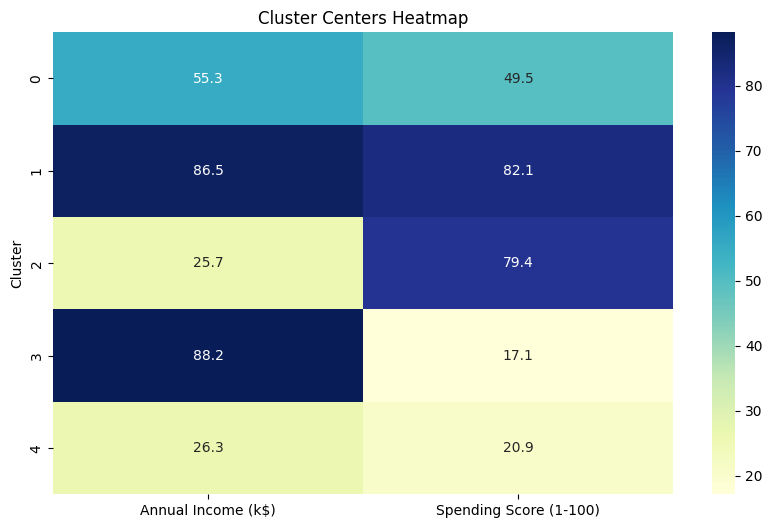

In [18]:
centers_df = pd.DataFrame(
    pipeline.named_steps['scaler'].inverse_transform(pipeline.named_steps['kmeans'].cluster_centers_),
    columns=features
)
centers_df.index.name = "Cluster"

plt.figure(figsize=(10, 6))
sns.heatmap(centers_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Centers Heatmap")
plt.show()

#### Radar (Spider) Plot of Cluster Centers

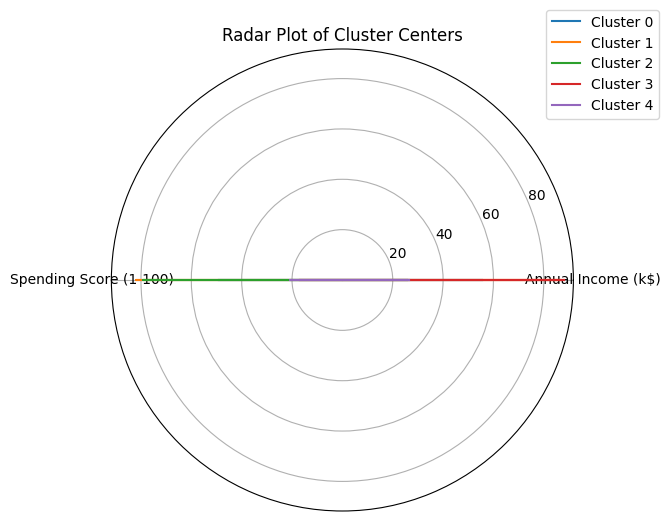

In [19]:
radar_df = centers_df.copy()
radar_df['Cluster'] = radar_df.index
radar_df = pd.melt(radar_df, id_vars='Cluster')

categories = features
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

for i, grp in radar_df.groupby("Cluster"):
    values = grp["value"].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.title("Radar Plot of Cluster Centers")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()

#### Save Model and CSV

In [20]:
joblib.dump(pipeline, "Model/Customer_Segmentation_Model.pkl")
df.to_csv("Output/Clustered_Customers.csv", index=False)

#### Predict on New Input

In [21]:
loaded_model = joblib.load("Model/Customer_Segmentation_Model.pkl")
sample = [[85, 65]]
cluster = loaded_model.predict(sample)
print(f"Predicted Cluster: {cluster[0]}")

Predicted Cluster: 1


#### Gradio Web Interface

In [22]:
def predict_cluster(income, score):
    model = joblib.load("Model/customer_segmentation_model.pkl")
    cluster = model.predict([[income, score]])[0]
    return f"Predicted Cluster: {cluster}"

gr.Interface(
    fn=predict_cluster,
    inputs=[
        gr.Slider(10, 150, label="Annual Income (k$)"),
        gr.Slider(1, 100, label="Spending Score (1-100)")
    ],
    outputs="text",
    title="Customer Cluster Predictor"
).launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
